In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [26]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [27]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0)
signals['signal'] = signals['signal'].shift(1)  # Shift the signal by one day to prevent look-ahead bias
 
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,NaN,768.700012,768.700012,NaN
1,0.0,765.415008,765.415008,NaN
2,0.0,764.283346,764.283346,0.0
3,0.0,768.842514,768.842514,0.0
4,0.0,773.176013,773.176013,0.0
...,...,...,...,...
247,0.0,976.255005,983.440002,0.0
248,0.0,982.058339,985.941671,0.0
249,0.0,986.876668,988.381668,0.0
250,0.0,994.908335,990.628337,0.0


The code you provided uses a moving average crossover strategy to generate buy and sell signals for a stock. The strategy works by first calculating two moving averages, a short-term moving average and a long-term moving average. The short-term moving average is calculated over a shorter period of time, while the long-term moving average is calculated over a longer period of time. The code then compares the two moving averages and generates a buy signal when the short-term moving average crosses above the long-term moving average and a sell signal when the short-term moving average crosses below the long-term moving average. The code also shifts the signals by one day to prevent look-ahead bias.


•	The first line of code defines the short-term and long-term moving average windows. The short-term window is 2.5% of the length of the data frame, while the long-term window is 5% of the length of the data frame.

•	The second line of code creates a DataFrame called signals. The signals DataFrame will store the buy and sell signals.

•	The third line of code sets all of the values in the signal column to 0.

•	The fourth line of code calculates the short-term and long-term moving averages.

•	The fifth line of code generates the buy and sell signals. The code uses the np.where() function to compare the short-term and long-term moving averages. If the short-term moving average is greater than the long-term moving average, the code assigns a value of 1 to the signal column. If the short-term moving average is less than the long-term moving average, the code assigns a value of -1 to the signal column.

•	The sixth line of code shifts the signals by one day. This is done to prevent look-ahead bias. Look-ahead bias occurs when you use information from the future to make decisions in the present. By shifting the signals by one day, we are preventing ourselves from using information from the future to make decisions about the past.

•	The seventh line of code creates a new column called positions. The positions column stores the difference between the signal column from one day to the next. A positive value in the positions column indicates a long position, while a negative value indicates a short position.

The output of the code is a DataFrame called signals. The signals DataFrame contains the following columns:

•	index: The index of the signals DataFrame is the same as the index of the df DataFrame.

•	signal: The signal column contains the buy and sell signals. A value of 1 indicates a buy signal, while a value of -1 indicates a sell signal.

•	positions: The positions column contains the positions. A positive value indicates a long position, while a negative value indicates a short position.


In [28]:
def buy_stock(
    current_price,
    signal,
    money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    current_price = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = money
    states_sell = []
    states_buy = []
    holdings = 1

    def buy(i, money, holdings):
        shares = money // current_price[i]
        if current_price[i] > money :
            print("Share price greater than investment")
        elif shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, money, current_price[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            money -= buy_units * current_price[i]
            holdings += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * current_price[i], money)
            )
            states_buy.append(0)
        return money, holdings

    for i in range(current_price.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1.0:
            money, holdings = buy(i, money, holdings)
            states_buy.append(i)
        elif state == -1.0:
            # Sell logic

            if holdings == 0:
                    print('day %d: cannot sell anything, holdings 0' % (i))
            else:
                if holdings > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = holdings
                holdings -= sell_units
                total_sell = sell_units * current_price[i]
                money += total_sell
                try:
                    invest = (
                        (current_price[i] - current_price[states_buy[-1]])
                        / current_price[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, money)
                )
            states_sell.append(i)
    invest = ((money - starting_money) / starting_money) * 100
    total_gains = money - starting_money
    return states_buy, states_sell, total_gains, invest

In [29]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 7: buy 1 units at price 754.020020, total balance 9245.979980
day 10, sell 1 units at price 764.479980, investment 1.387226 %, total balance 10010.459960,
day 16: buy 1 units at price 761.679993, total balance 9248.779967
day 21, sell 1 units at price 750.500000, investment -1.467807 %, total balance 9999.279967,
day 27: buy 1 units at price 789.270020, total balance 9210.009947
day 38, sell 1 units at price 785.049988, investment -0.534675 %, total balance 9995.059935,
day 46: buy 1 units at price 804.789978, total balance 9190.269957
day 63, sell 1 units at price 801.489990, investment -0.410043 %, total balance 9991.759947,
day 70: buy 1 units at price 820.450012, total balance 9171.309935
day 85, sell 1 units at price 835.369995, investment 1.818512 %, total balance 10006.679930,
day 86: buy 1 units at price 838.679993, total balance 9167.999937
day 97, sell 1 units at price 814.429993, investment -2.891448 %, total balance 9982.429930,
day 105: buy 1 units at price 831.409973,

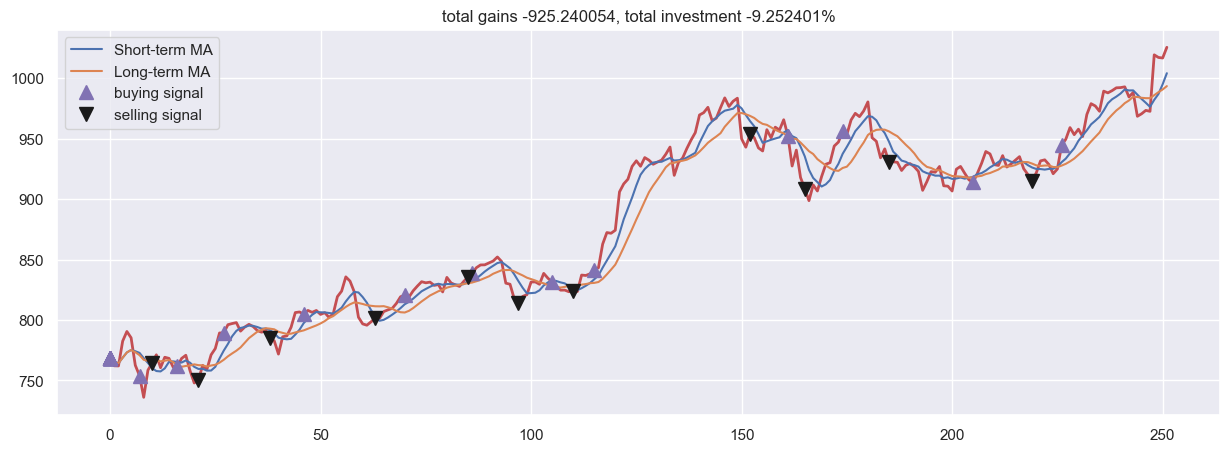

In [30]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
# Plot moving average lines
plt.plot(signals['short_ma'], label='Short-term MA')
plt.plot(signals['long_ma'], label='Long-term MA')
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

The time complexity of the provided code is dominated by the operations that iterate over the DataFrame, which have a time complexity of O(n). The other operations have a time complexity of O(1) or O(n) depending on whether they operate on a single element or the entire DataFrame.